In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import statistics
import math

In [2]:
df = pd.read_csv("data/tof_paper_2.csv")  # เปลี่ยนชื่อไฟล์ตามตำแหน่งที่เก็บ
df['timestamp'] = pd.to_datetime(df['timestamp_iso'])
raw_tof = df['tof'].tolist()

In [3]:
# ============ Parameters ============
WINDOW_SIZE = 5
SAMPLE_RATE = 5  # Hz
CUTOFF_FREQ = 1.0  # Hz

# ============ Filters ============

class MovingAverageFilter:
    def __init__(self, window_size):
        self.values = deque(maxlen=window_size)

    def filter(self, new_value):
        self.values.append(new_value)
        return sum(self.values) / len(self.values)

class MedianFilter:
    def __init__(self, window_size):
        self.values = deque(maxlen=window_size)

    def filter(self, new_value):
        self.values.append(new_value)
        return statistics.median(self.values)

class LowPassFilter:
    def __init__(self, cutoff_freq, sample_rate):
        self.dt = 1.0 / sample_rate
        self.alpha = (2 * math.pi * cutoff_freq * self.dt) / (2 * math.pi * cutoff_freq * self.dt + 1)
        self.last_output = None

    def filter(self, new_value):
        if self.last_output is None:
            self.last_output = new_value
        else:
            self.last_output = self.alpha * new_value + (1 - self.alpha) * self.last_output
        return self.last_output

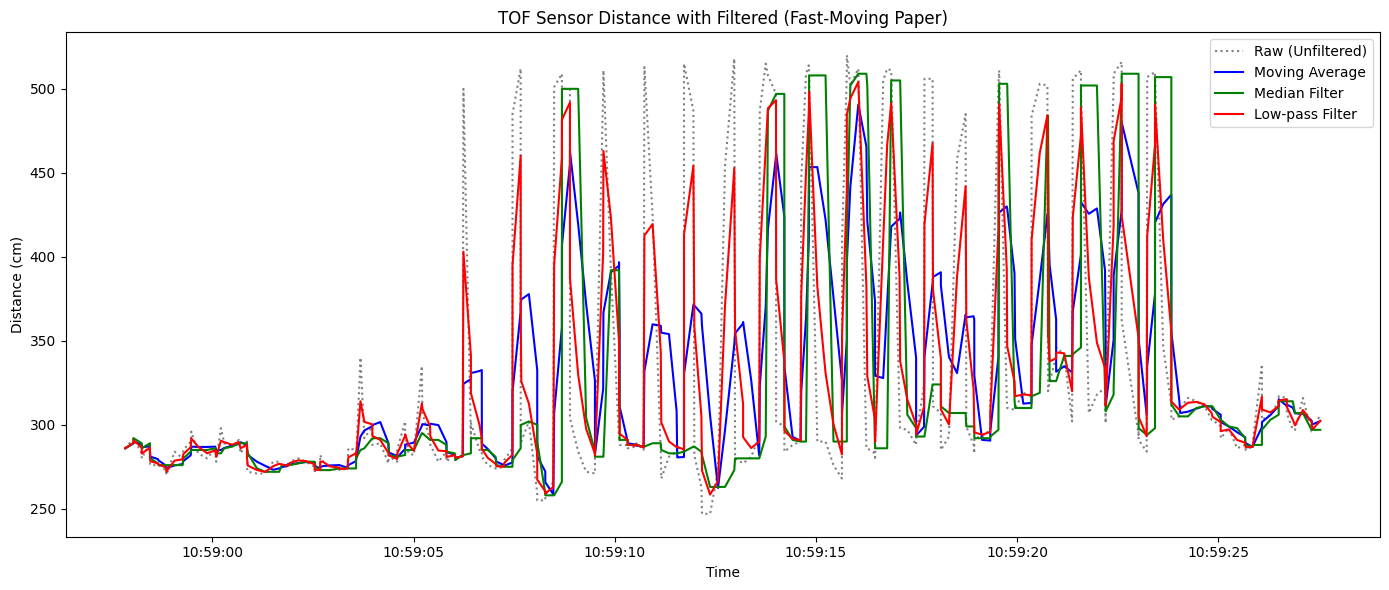

In [4]:
# ============ Apply Filters ============
ma_filter = MovingAverageFilter(WINDOW_SIZE)
med_filter = MedianFilter(WINDOW_SIZE)
lp_filter = LowPassFilter(CUTOFF_FREQ, SAMPLE_RATE)

filtered_ma = [ma_filter.filter(v) for v in raw_tof]
filtered_med = [med_filter.filter(v) for v in raw_tof]
filtered_lp = [lp_filter.filter(v) for v in raw_tof]

# ============ Plot ============
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], raw_tof, label='Raw (Unfiltered)', color='gray', linestyle='dotted')
plt.plot(df['timestamp'], filtered_ma, label='Moving Average', color='blue')
plt.plot(df['timestamp'], filtered_med, label='Median Filter', color='green')
plt.plot(df['timestamp'], filtered_lp, label='Low-pass Filter', color='red')

plt.title('TOF Sensor Distance with Filtered (Fast-Moving Paper)')
plt.xlabel('Time')
plt.ylabel('Distance (cm)')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()